In [1]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels


In [43]:
import pandas as pd

data_stock = pd.read_csv('../data/cleaned_IBM.csv')


## sktime testing sets

### naive forecaster

In [40]:
y = load_airline()
type(y.index)

pandas.core.indexes.period.PeriodIndex

In [44]:
y = data_stock
type(y.index)

pandas.core.indexes.range.RangeIndex

In [45]:
y

,Close
0,121.021324
1,120.355675
2,119.566719
3,119.566719
4,119.566719
...,...
4009,162.139999
4010,163.210007
4011,163.460007
4012,163.750000


In [ ]:
pi = df.index.to_period('D')

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

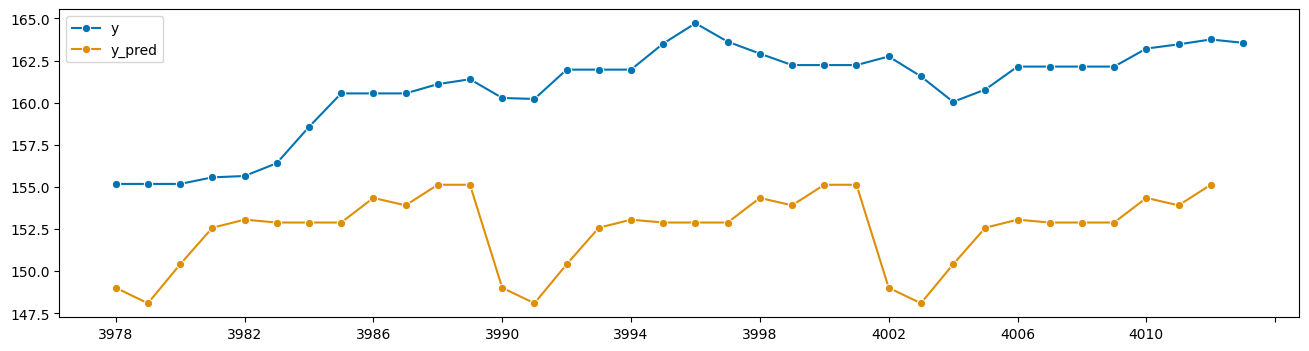

In [61]:
# AIRLINE TEST
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_error
from sktime.utils.plotting import plot_series

# step 1: data specification
y = load_airline()
y = data_stock

# step 2: specifying forecasting horizon
fh = np.arange(1, len(y_test))

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y_train)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y_test, y_pred, labels=["y", "y_pred"])

In [52]:
(y_test)

,Close
3978,155.179993
3979,155.179993
3980,155.179993
3981,155.570007
3982,155.649994
3983,156.410004
3984,158.559998
3985,160.550003
3986,160.550003
3987,160.550003


In [12]:
data_stock.shape

(4014, 1)

## train test split

694 36


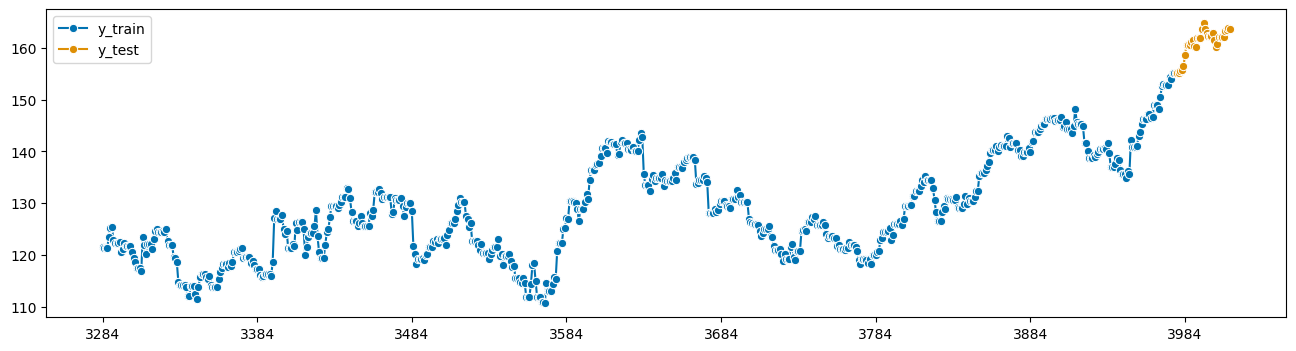

In [55]:
# airline test 2
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split

y = load_airline()
y = data_stock[(4014-365*2):4014]
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train

# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [26]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

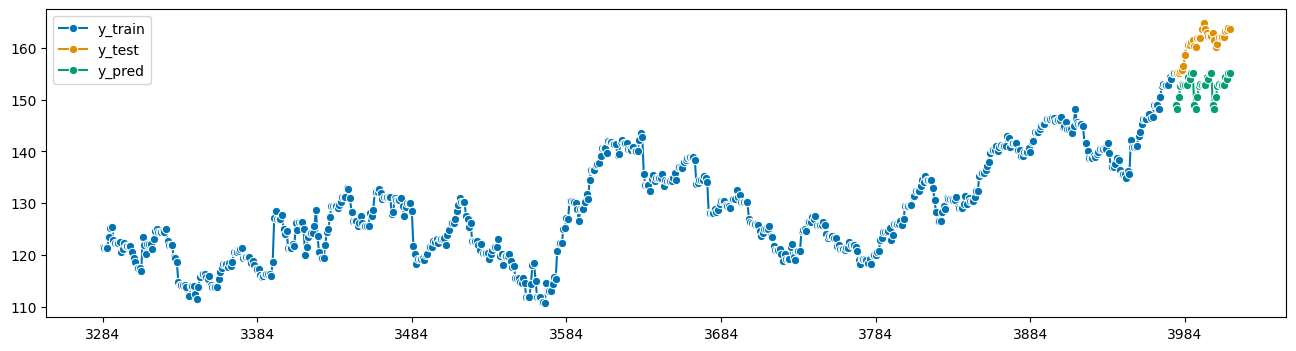

In [27]:
# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [28]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
# note: the FIRST argument is the ground truth, the SECOND argument are the forecasts
#       the order matters for most metrics in general

0.051674420404607596

### AutoARIMA 

In [29]:
y_train.shape

(694, 1)

In [76]:
y_train.iloc[-365: ,]

,Close
3613,141.711868
3614,141.349838
3615,141.349838
3616,141.349838
3617,139.263458
...,...
3973,152.889999
3974,154.350006
3975,153.910004
3976,155.130005


In [85]:
y_train.index

Index([3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293,
       ...
       3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977],
      dtype='int64', length=694)

In [83]:
# AutoARIMA AIRLINE TEST test
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

from sktime.forecasting.model_selection import ForecastingGridSearchCV

#param_grid = {'p': [0, 1, 2], 'd': [0, 1, 2], 'q': [0, 1, 2]}
#gscv = ForecastingGridSearchCV(forecaster=AutoARIMA(), param_grid=param_grid, cv=SlidingWindowSplitter(fh=[0]))
#gscv.fit(y_train.iloc[-365: ,])

#print('Best parameters: ', gscv.best_params_)
#print('Best model: ', gscv.best_forecaster_)

#without gridsearch
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

In [84]:
forecaster.fit(y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [81]:
fh = ForecastingHorizon(y_test.index, is_relative=False)


In [82]:
yhat = forecaster.predict(fh)


NotFittedError: This instance of AutoARIMA has not been fitted yet; please call `fit` first.

In [35]:
df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.023878,0.782905,0.004468,72,3355
1,0.019058,0.864300,0.005541,84,3367
2,0.023012,0.994209,0.004994,96,3379
3,0.061537,2.529067,0.006941,108,3391
4,0.022244,2.736204,0.003068,120,3403
5,0.027820,4.644486,0.005236,132,3415
6,0.064256,3.399158,0.005411,144,3427
7,0.022839,1.367797,0.006905,156,3439
8,0.019367,1.994161,0.005685,168,3451
9,0.016902,3.377375,0.004774,180,3463


In [71]:
#autoARIMA_eval_df= df.copy()
autoARIMA_eval_df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.023878,0.782905,0.004468,72,3355
1,0.019058,0.864300,0.005541,84,3367
2,0.023012,0.994209,0.004994,96,3379
3,0.061537,2.529067,0.006941,108,3391
4,0.022244,2.736204,0.003068,120,3403
5,0.027820,4.644486,0.005236,132,3415
6,0.064256,3.399158,0.005411,144,3427
7,0.022839,1.367797,0.006905,156,3439
8,0.019367,1.994161,0.005685,168,3451
9,0.016902,3.377375,0.004774,180,3463


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

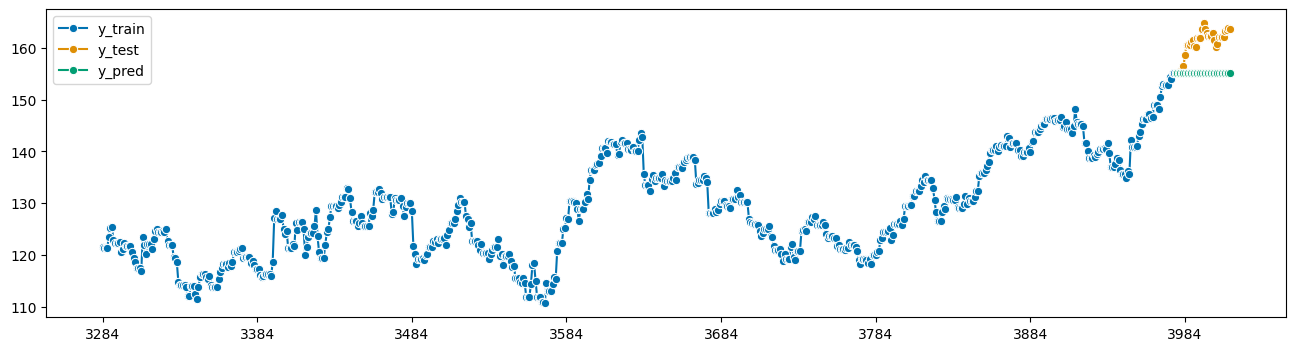

In [37]:
plot_series(y_train, y_test, yhat, labels=["y_train", "y_test", "y_pred"])

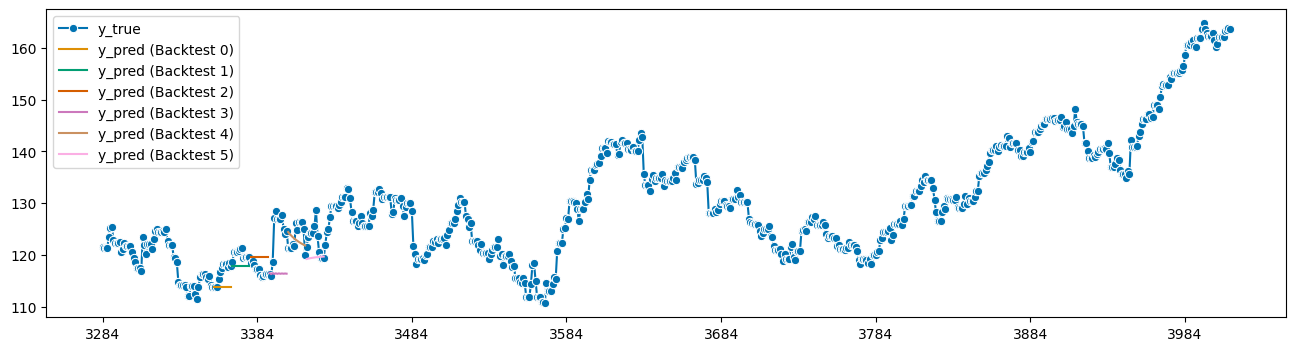

In [36]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

### kneighbors -- make_reduction

0.12887507224382988

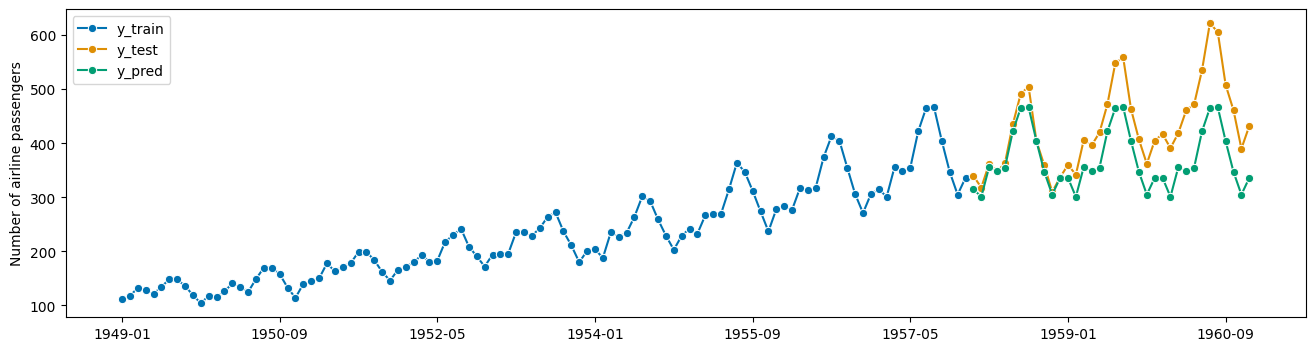

In [9]:
## kneighbors
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=1) #regressor params for tuning
forecaster = make_reduction(regressor, window_length=15, strategy="recursive") #window length params for tuning

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)


In [10]:
forecaster.get_params()

{'estimator': KNeighborsRegressor(n_neighbors=1),
 'pooling': 'local',
 'transformers': None,
 'window_length': 15,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

A common composition motif is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data.

In [11]:
pm.auto_arima(train, seasonal=True, m=12)

NameError: name 'pm' is not defined

### forecasting pipeline

In [ ]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
forecaster = Deseasonalizer(model="multiplicative", sp=12) * ARIMA()
forecaster

In [ ]:
forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * ARIMA()
)

forecaster.get_params()

In [ ]:
from sktime.transformations.series.func_transform import FunctionTransformer

forecaster = ARIMA() * FunctionTransformer(lambda y: y.round())
forecaster.fit_predict(y, fh=fh).head(3)

In [ ]:
forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * ARIMA()
    * FunctionTransformer(lambda y: y.round())
)

forecaster.fit_predict(y_train, fh=fh).head(3)

## pmdarima

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, forecasts)
print('MAE: %.3f' % mae)


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, forecasts)
print('MSE: %.3f' % mse)
